In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
plt.rcParams['figure.figsize'] = [20, 7]

In [2]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

In [10]:
# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [11]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Text(0.5, 1.0, 'AUTOMOTIVE Sales at Store 3')

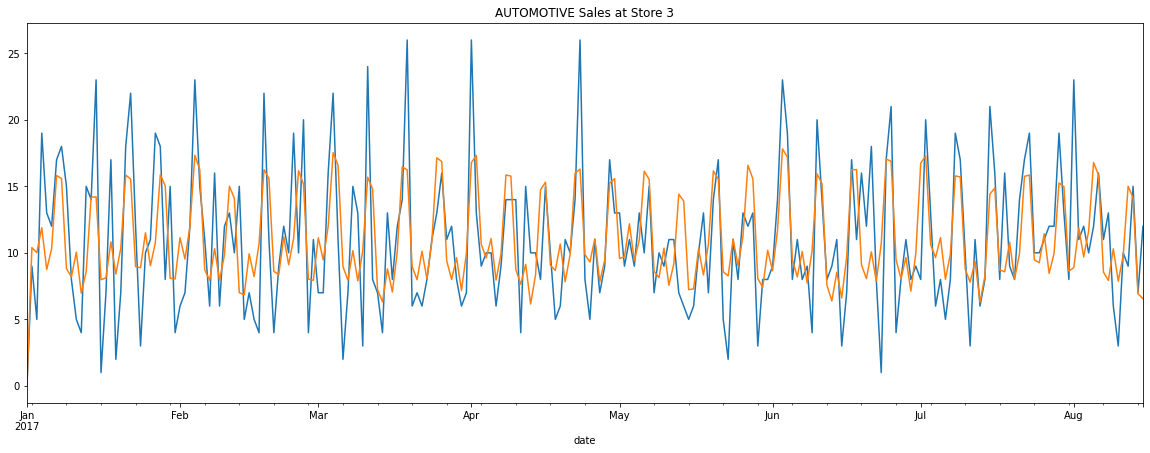

In [12]:
STORE_NBR = '3'  # 1 - 54
FAMILY = 'AUTOMOTIVE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot()
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')

In [6]:
# df_test = pd.read_csv(
#     'test.csv',
#     dtype={
#         'store_nbr': 'category',
#         'family': 'category',
#         'onpromotion': 'uint32',
#     },
#     parse_dates=['date'],
#     infer_datetime_format=True,
# )
# df_test['date'] = df_test.date.dt.to_period('D')
# df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()
#
# # Create features for test set
# X_test = dp.out_of_sample(steps=16)
# X_test.index.name = 'date'
# X_test['NewYear'] = (X_test.index.dayofyear == 1)
#
#
# y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
# y_submit = y_submit.stack(['store_nbr', 'family'])
# y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
# y_submit.to_csv('submission.csv', index=False)